In [ ]:
#Import processed data for clustering
 
import pandas as pd

df = pd.read_csv("../data-raw/crypto-markets-processed.csv")
df['date'] = pd.to_datetime(df['date'])
print(df.shape)
df.head()

(776561, 20)


,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,daily_return,volume_change,sma_7,ema_14,rsi_14,atr_14,label
0,0chain,ZCN,0chain,2018-07-17,441,0.426759,0.529069,0.421942,0.497478,121127.0,19899120.0,0.7051,0.11,0.165712,0.446552,0.449708,0.506991,49.929569,0.066502,1
1,0chain,ZCN,0chain,2018-07-18,441,0.497499,0.518483,0.457703,0.486524,62921.0,19460960.0,0.4742,0.06,-0.022060,-0.480537,0.454008,0.504262,48.334177,0.065893,0
2,0chain,ZCN,0chain,2018-07-19,441,0.486397,0.486397,0.439271,0.440240,87071.0,17609600.0,0.0206,0.05,-0.094896,0.383815,0.458029,0.495726,42.198661,0.063976,0
3,0chain,ZCN,0chain,2018-07-20,441,0.440344,0.440344,0.388898,0.396128,135686.0,15845120.0,0.1405,0.05,-0.100412,0.558337,0.451438,0.482446,37.334404,0.062726,0
4,0chain,ZCN,0chain,2018-07-21,441,0.396202,0.399500,0.374099,0.379937,61702.0,15197480.0,0.2298,0.03,-0.041052,-0.545259,0.440131,0.468778,35.707439,0.059107,0


In [ ]:
#Scale and standardize numeric features. Original and scaled values available in same dataframe

from sklearn.preprocessing import StandardScaler

#Specifying which features to scale (exclude open, high, low, and close as correlated and part of other indicators)
features_to_scale = ['daily_return', 'spread', 'close_ratio', 'volume_change', 'sma_7', 'ema_14', 'rsi_14', 'atr_14', 'market']

#Ensure any rows with nulls are dropped just in case
df_scaled = df.dropna(subset=features_to_scale).copy()

#Scale the features using standard scaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_scaled[features_to_scale])

#Add scaled values back to a new DataFrame
import numpy as np
scaled_df = pd.DataFrame(scaled_values, columns=[f + '_scaled' for f in features_to_scale])
df_scaled = pd.concat([df_scaled.reset_index(drop=True), scaled_df], axis=1)

In [6]:
#Select the scaled features
features_scaled = [f + '_scaled' for f in [
    'daily_return', 'spread', 'close_ratio', 'volume_change',
    'sma_7', 'ema_14', 'rsi_14', 'atr_14', 'market'
]]

X = df_scaled[features_scaled].values

c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

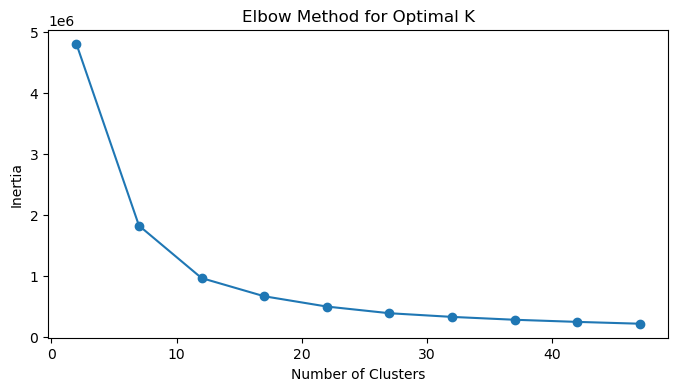

In [ ]:
#Run K-Means model for Pattern Discovery over time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

#Use variable ranges for K to interatively find good range which will include elbow to identify optimal K
inertias = []
K = list(range(2, 51, 5))

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [9]:
k_optimal = 12  #visually obtained from graph above
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_scaled['kmeans_cluster'] = kmeans.fit_predict(X)

c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


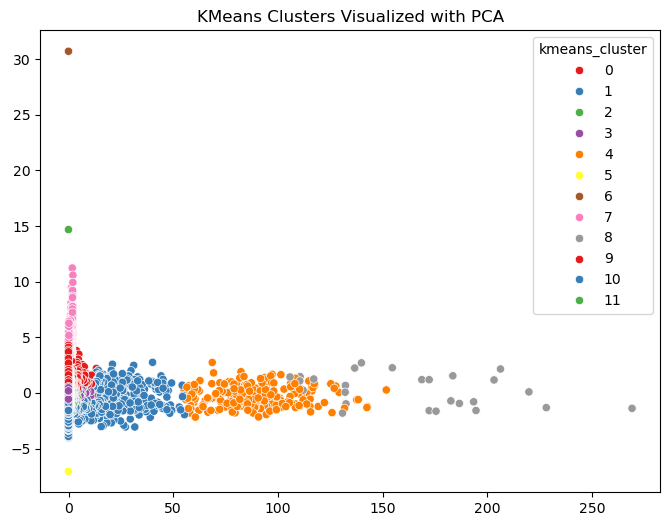

In [11]:
# Compare average indicator values per cluster
df_scaled.groupby('kmeans_cluster')[features_scaled].mean()

# Optionally: visualize with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_scaled['kmeans_cluster'], palette='Set1')
plt.title("KMeans Clusters Visualized with PCA")
plt.show()

<Axes: >

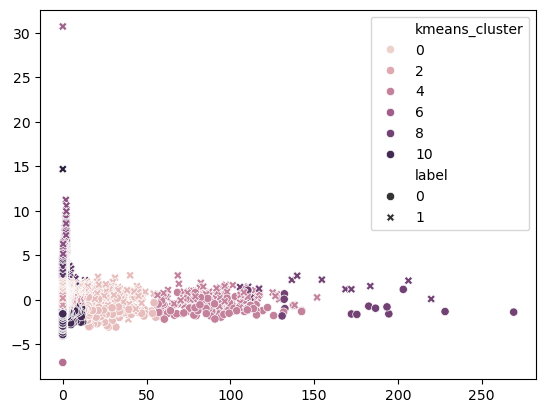

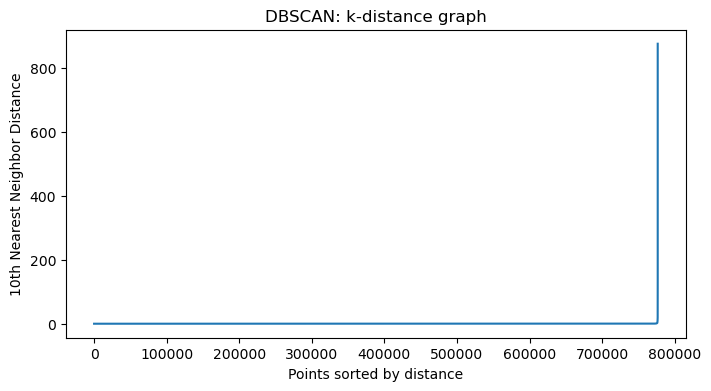

In [10]:
#Run DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find a good eps value by k-distance plot
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("DBSCAN: k-distance graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("10th Nearest Neighbor Distance")
plt.show()

In [ ]:
#Run K-Means with coins aggregated at coin level